## Random Forest Example

Import packages

In [1]:
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import ensemble
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

The california housing dataset below is built in within Sklearn. Original dataset comes from 1990 US Census.

In [2]:
X, y = fetch_california_housing(return_X_y=True, as_frame = True)
X.shape

(20640, 8)

### Feature descriptions

Unit of observation is a district in California.
All features are numeric.

* `MedInc` median income
* `HouseAge` median house age
* `AveRooms` average number of rooms
* `AveBedrms` average number of bedrooms
* `Population` district population
* `AveOccup` average house occupancy
* `Latitude` center of district latitude
* `Longitude` center of district longitude

In [3]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Target is median house value for california districts (in hundrends-of-thousands of USD (assuming)).

In [4]:
y.describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

Transform X object from Pandas DataFrame to numpy array. I tend to see numpy arrays being compatabable with more aspects of sklearn over pandas dataframes.

In [5]:
X = X.to_numpy()

### Split data into train and test sets

With Sklearn, we will split our data into training and test sets. We do an 80/20 split and set a seed for splitting.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state = 12)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10320, 8)
(10320, 8)
(10320,)
(10320,)


### Preprocessing

Suppose we truly do not care about interpretability or any measures of variable importance and only want to get the best prediction possible. We can use PCA for dimension reduction, but first we want to preprocess with feature scaling, 
setting all features to have mean 0 and SD 1.

We first start with the `preprocessing` module from sklearn, using the `StandardScalar` function. We fit our dataset X_train within the StandardScaler class.

In [7]:
scaler = preprocessing.StandardScaler().fit(X_train)

Scaler is now an object that can return many different results due to the StandardScaler class.  
For example, pre-transformation, we can return the means and standard deviations of our columns.

In [8]:
# Get means of all columns 
print(scaler.mean_)

# Get means of 1 column
print(scaler.mean_[2])

# Get standard deviation of 1 column
print(scaler.scale_[2])

[ 3.86591940e+00  2.85433140e+01  5.45666208e+00  1.10309841e+00
  1.43376512e+03  3.16901109e+00  3.56277345e+01 -1.19565436e+02]
5.456662077464308
2.8825796099362266


Of course, we can standardize the training data.

In [9]:
X_train_scaled = scaler.transform(X_train)
print(X_train_scaled.mean(axis = 0))

[-6.51395389e-16 -3.46729536e-17  4.43897987e-15  5.53937010e-15
 -6.69482235e-17  3.91496159e-16 -3.15682880e-14 -1.88218455e-13]


The scaler object has saved the values that were used to standardize the training data.  
**We can use the scaler object to transform the test data to the same scale.**

In [10]:
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled.mean(axis = 0))

[ 0.00501209  0.0153485  -0.01919276 -0.02220812 -0.01500458 -0.01360316
  0.00385724 -0.00427268]


Notice how the values aren't as close to 0 as the for the training data. The scaling on the testing data is done in reference to the training data, **which is vital for testing a model appropriately.**

### Dimension Reduction with PCA

Let's suppose I wanted to use PCA to reduce my 8 feature space to a 5 feature space.  
PCA will create 8 principal components, but we will only use the first 5 components to create our random forest.

In [11]:
pca = decomposition.PCA(n_components = 5)

# Fits PCA to scaled training dataset.
# The pca object now has the information that we want 5 components and are using the X_train_scaled data
    # to make PCs.
pca.fit(X_train_scaled)

PCA(n_components=5)

Of course, we can execute PCA on the scaled training data.

In [12]:
X_train_pca = pca.transform(X_train_scaled)
X_train_pca.shape

(10320, 5)

Recall that the formulation of PCs is of closed form by taking linear combinations of the original columns.  Again, **we can apply these same transformations to our test data.**

In [13]:
X_test_pca = pca.transform(X_test_scaled)
X_test_pca.shape

(10320, 5)

If wanted to keep the same name, can do!

In [14]:
X_train_scaled2 = X_train_scaled
print(pca.fit_transform(X_train_scaled2).shape)

(10320, 5)


### Random Forest model with Gridsearch

Basic hyperparameters:

* `n_estimators`: Number of trees in forest
* `criterion`: MSE or MAE (methods of determining optimal feature choice at node)
* `max_depth`: Maximum depth of the tree
* `min_samples_split`: Minimum number of observations needed to split a node
* `max_features`: Number of features to consider when looking for the best split

**Note: below is not really how we would want to train this dataset. In reality, too few features to make RF worthwhile. For demonstration purposes only!**

In [15]:
start = time.time()

# Create the grid itself
param_grid = {
    'n_estimators': [10],
    'criterion': ["mae"],
    'max_depth': [2],
    'max_features': [3],
    'min_samples_split': [20, 30]
}

# Create a random forest model object
rfmodel = ensemble.RandomForestRegressor()

# Create the grid search model
    # 3 folds (cv)
    # n_jobs = - 1 => all processors available
    # verbose is about level of info printed out.
grid_search = GridSearchCV(estimator = rfmodel,
                           param_grid = param_grid,
                           cv = 3,
                           n_jobs = 1,
                           verbose = 2)

Now execute the gridsearch! (Takes about 45 seconds)

In [16]:
grid_search.fit(X_train_pca, y_train)
end = time.time()
print(end - start)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END criterion=mae, max_depth=2, max_features=3, min_samples_split=20, n_estimators=10; total time=   3.8s
[CV] END criterion=mae, max_depth=2, max_features=3, min_samples_split=20, n_estimators=10; total time=   3.8s
[CV] END criterion=mae, max_depth=2, max_features=3, min_samples_split=20, n_estimators=10; total time=   3.6s
[CV] END criterion=mae, max_depth=2, max_features=3, min_samples_split=30, n_estimators=10; total time=   4.0s
[CV] END criterion=mae, max_depth=2, max_features=3, min_samples_split=30, n_estimators=10; total time=   4.4s
[CV] END criterion=mae, max_depth=2, max_features=3, min_samples_split=30, n_estimators=10; total time=   4.1s
35.623379945755005


Can get best hyperparameters from gridseach

In [17]:
grid_search.best_params_

{'criterion': 'mae',
 'max_depth': 2,
 'max_features': 3,
 'min_samples_split': 30,
 'n_estimators': 10}

### Fit chosen model onto test data

In [18]:
y_score = grid_search.predict(X_test_pca)
MAE = (y_test - y_score).abs()

### Model fit visualizations

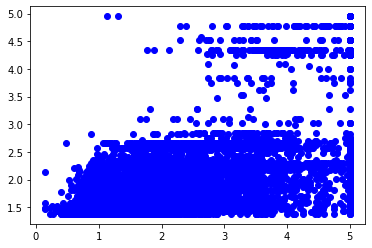

In [19]:
plt.plot(y_test, y_score, 'bo')

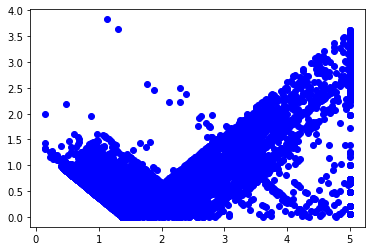

In [20]:
plt.plot(y_test, MAE, 'bo')